In [23]:
# Import the pandas library
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
from xgboost import XGBRegressor

In [ ]:
# Load the scraped data into a DataFrame
df = pd.read_csv('cardiff_properties_final.csv')

In [5]:
# General inspection of the data
print("--- Data Info ---")
df.info()
print("\n--- First 5 Rows ---")
print(df.head())
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     1050 non-null   object 
 1   address   1050 non-null   object 
 2   bedrooms  1045 non-null   float64
 3   url       1050 non-null   object 
dtypes: float64(1), object(3)
memory usage: 32.9+ KB

--- First 5 Rows ---
      price                               address  bedrooms  \
0  £220,000             Church Street, Caerphilly       3.0   
1  £320,000                 Ethel Street, Cardiff       2.0   
2  £265,000       Ael-y-Bryn, Llanedeyrn, Cardiff       3.0   
3  £395,000  Clodien Avenue, Heath, Cardiff, CF14       3.0   
4  £280,000    Victoria Road, Whitchurch, Cardiff       2.0   

                                                 url  
0  https://www.rightmove.co.uk/properties/1636862...  
1  https://www.rightmove.co.uk/properties/1641851...  
2  https://www.rightmov

In [ ]:
# --- Cleaning the 'price' column ---

# Create a copy to avoid modifying the original data directly
df_cleaned = df.copy()

# Remove '£' and ',' from the price, then convert it to a number (integer)
# The .astype(int) converts the column to a numerical type
df_cleaned['price'] = df_cleaned['price'].str.replace('£', '').str.replace(',', '').astype(int)

In [7]:
# --- Cleaning the 'bedrooms' column ---

# Convert bedrooms to a numeric type, turning non-numeric values (like 'N/A') into errors
# The 'coerce' option turns any errors into 'NaT' (Not a Time), which is pandas' null value for numbers
df_cleaned['bedrooms'] = pd.to_numeric(df_cleaned['bedrooms'], errors='coerce')

# Now need to handle the missing bedroom values
# Calculate the mode (most common value) of the 'bedrooms' column
bedroom_mode = df_cleaned['bedrooms'].mode()[0]

# Fill the missing values with the mode
df_cleaned['bedrooms'].fillna(bedroom_mode, inplace=True)

# Convert the 'bedrooms' column to a whole number (integer)
df_cleaned['bedrooms'] = df_cleaned['bedrooms'].astype(int)

print("--- Missing values handled ---")
print(df_cleaned.info())

--- Missing values handled ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   price     1050 non-null   int64 
 1   address   1050 non-null   object
 2   bedrooms  1050 non-null   int64 
 3   url       1050 non-null   object
dtypes: int64(2), object(2)
memory usage: 32.9+ KB
None


/var/folders/1x/jd5z26n95f5cp57xyfhcd07m0000gn/T/ipykernel_42408/3109138947.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['bedrooms'].fillna(bedroom_mode, inplace=True)


In [8]:
# See the results of the cleaning
print("\n--- Cleaned Data Info ---")
df_cleaned.info()
print("\n--- First 5 Rows of Cleaned Data ---")
print(df_cleaned.head())


--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   price     1050 non-null   int64 
 1   address   1050 non-null   object
 2   bedrooms  1050 non-null   int64 
 3   url       1050 non-null   object
dtypes: int64(2), object(2)
memory usage: 32.9+ KB

--- First 5 Rows of Cleaned Data ---
    price                               address  bedrooms  \
0  220000             Church Street, Caerphilly         3   
1  320000                 Ethel Street, Cardiff         2   
2  265000       Ael-y-Bryn, Llanedeyrn, Cardiff         3   
3  395000  Clodien Avenue, Heath, Cardiff, CF14         3   
4  280000    Victoria Road, Whitchurch, Cardiff         2   

                                                 url  
0  https://www.rightmove.co.uk/properties/1636862...  
1  https://www.rightmove.co.uk/properties/1641851...  
2  https://www.rig

In [9]:
# --- Feature Engineering: Extract Postcode and Create New Column ---

# This regex finds patterns like CF10, CF24, etc., at the end of the address string
outward_code_regex = r'\b(CF\d{1,2}|NP\d{1,2})\b'

# The .str.extract() method applies this regex to the 'address' column
df_cleaned['postcode_area'] = df_cleaned['address'].str.extract(outward_code_regex, flags=re.IGNORECASE)



In [10]:
print("\n--- First 5 rows with new 'postcode_area' column ---")
print(df_cleaned.head())
print(f"Total rows: {len(df_cleaned)}")
print(df_cleaned.isnull().sum())


--- First 5 rows with new 'postcode_area' column ---
    price                               address  bedrooms  \
0  220000             Church Street, Caerphilly         3   
1  320000                 Ethel Street, Cardiff         2   
2  265000       Ael-y-Bryn, Llanedeyrn, Cardiff         3   
3  395000  Clodien Avenue, Heath, Cardiff, CF14         3   
4  280000    Victoria Road, Whitchurch, Cardiff         2   

                                                 url postcode_area  
0  https://www.rightmove.co.uk/properties/1636862...           NaN  
1  https://www.rightmove.co.uk/properties/1641851...           NaN  
2  https://www.rightmove.co.uk/properties/1641844...           NaN  
3  https://www.rightmove.co.uk/properties/1641840...          CF14  
4  https://www.rightmove.co.uk/properties/1641552...           NaN  
Total rows: 1050
price              0
address            0
bedrooms           0
url                0
postcode_area    718
dtype: int64


In [11]:
failed_postcodes = df_cleaned[df_cleaned['postcode_area'].isnull()]

print("--- Examples of Addresses Where Postcode Extraction Failed ---")

# Print the full 'address' column for the first 15 failed rows without cutting them off
print(failed_postcodes['address'].head(15).to_string())

--- Examples of Addresses Where Postcode Extraction Failed ---
0                       Church Street, Caerphilly
1                           Ethel Street, Cardiff
2                 Ael-y-Bryn, Llanedeyrn, Cardiff
4              Victoria Road, Whitchurch, Cardiff
5              Ton-yr-ywen Avenue, Heath, Cardiff
6       Dan Yr Allt Close, Rhydyfelin, Pontypridd
7                Kimberley Road, Penylan, Cardiff
8              Cathedral Road, Pontcanna, Cardiff
11                        St. Marys Avenue, Barry
12                       Pentrebane Road, Cardiff
13    John Batchelor Way, Penarth Marina, Penarth
15                      Glamorgan Street, Cardiff
16                Plasnewydd Road, Roath, Cardiff
17             The Anchorage, River Walk, Penarth
18                        12 Pill Street, Penarth


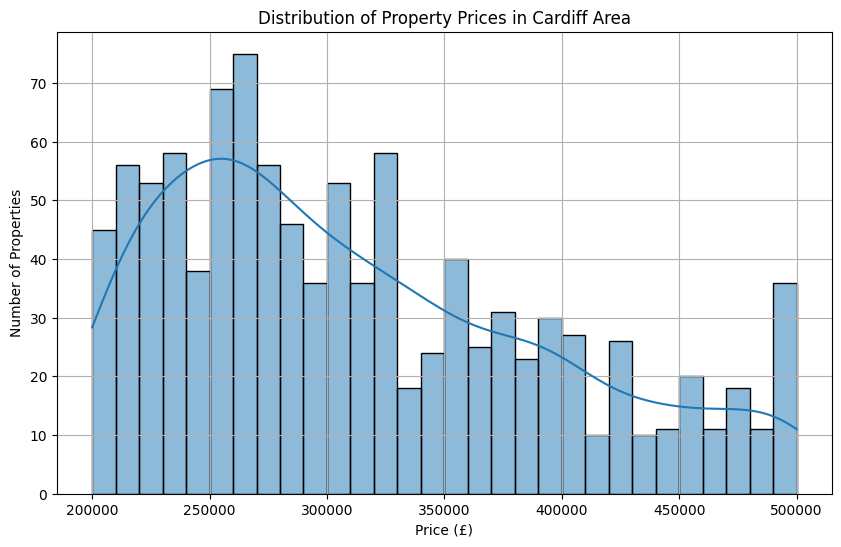

In [12]:
# --- First Visualization: Distribution of Prices ---
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['price'], kde=True, bins=30)
plt.title('Distribution of Property Prices in Cardiff Area')
plt.xlabel('Price (£)')
plt.ylabel('Number of Properties')
plt.grid(True)
plt.show()

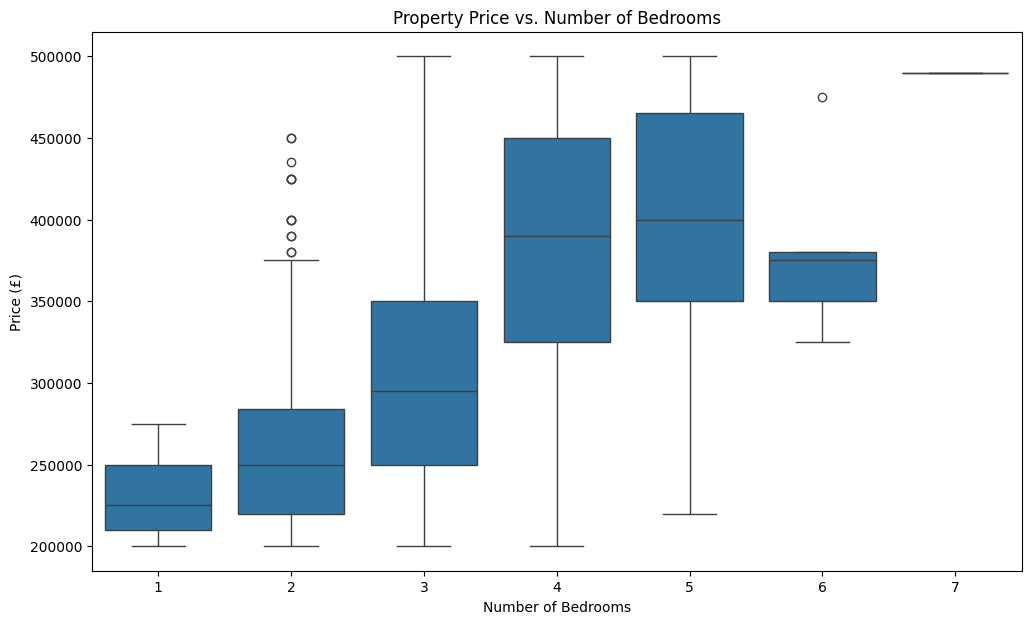

In [13]:
# --- Visualization: Price by Bedrooms ---
plt.figure(figsize=(12, 7))
sns.boxplot(x='bedrooms', y='price', data=df_cleaned)
plt.title('Property Price vs. Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Price (£)')
plt.show()

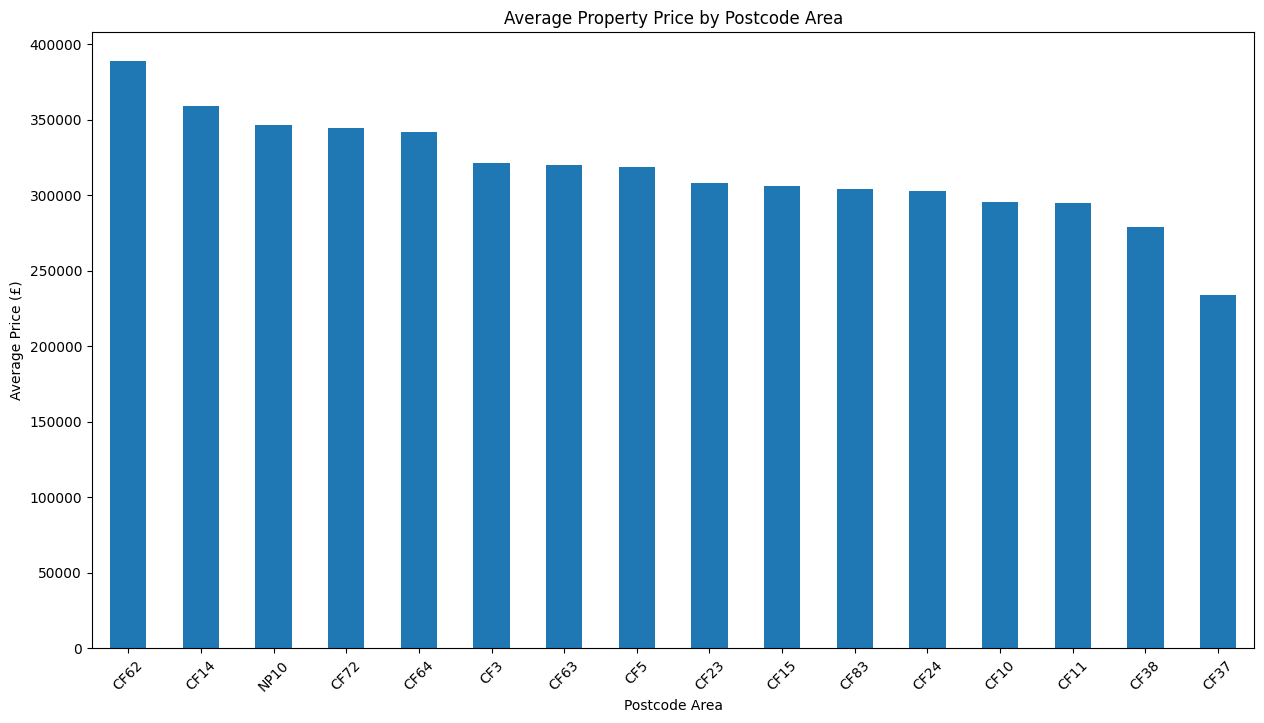

In [14]:
# --- Visualization: Price by Postcode Area ---
# Calculate the average price for each postcode area
avg_price_by_postcode = df_cleaned.groupby('postcode_area')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
avg_price_by_postcode.plot(kind='bar')
plt.title('Average Property Price by Postcode Area')
plt.xlabel('Postcode Area')
plt.ylabel('Average Price (£)')
plt.xticks(rotation=45)
plt.show()

In [15]:
# --- Prepare Data with One-Hot Encoding ---
# Use pandas to convert the 'postcode_area' column into numerical columns
df_model_ready = pd.get_dummies(df_cleaned, columns=['postcode_area'], drop_first=True)

print("--- Data Head after One-Hot Encoding ---")
print(df_model_ready.head())

--- Data Head after One-Hot Encoding ---
    price                               address  bedrooms  \
0  220000             Church Street, Caerphilly         3   
1  320000                 Ethel Street, Cardiff         2   
2  265000       Ael-y-Bryn, Llanedeyrn, Cardiff         3   
3  395000  Clodien Avenue, Heath, Cardiff, CF14         3   
4  280000    Victoria Road, Whitchurch, Cardiff         2   

                                                 url  postcode_area_CF11  \
0  https://www.rightmove.co.uk/properties/1636862...               False   
1  https://www.rightmove.co.uk/properties/1641851...               False   
2  https://www.rightmove.co.uk/properties/1641844...               False   
3  https://www.rightmove.co.uk/properties/1641840...               False   
4  https://www.rightmove.co.uk/properties/1641552...               False   

   postcode_area_CF14  postcode_area_CF15  postcode_area_CF23  \
0               False               False               False   
1    

In [16]:
# --- Select Features (X) and Target (y) ---
# Drop the original 'address' and 'url' columns as they are not needed for the model
df_model_ready = df_model_ready.drop(['address', 'url'], axis=1)

# X contains all columns EXCEPT for the 'price' column
X = df_model_ready.drop('price', axis=1)

# y contains ONLY the 'price' column
y = df_model_ready['price']

In [17]:
# --- Split Data into Training and Testing Sets ---
# This splits the data: 80% for training the model, 20% for testing it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Split Complete ---")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


--- Data Split Complete ---
Training data shape: (840, 16)
Testing data shape: (210, 16)


In [18]:
# --- Linear Regression Model ---

print("--- Training Linear Regression Model ---")

# Initialize the model
lr_model = LinearRegression()

# Train the model using your training data
lr_model.fit(X_train, y_train)

# Use the trained model to make predictions on the unseen test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate how well the model performed
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - Mean Absolute Error: £{mae_lr:,.2f}")
print(f"Linear Regression - R-squared: {r2_lr:.2f}")

--- Training Linear Regression Model ---
Linear Regression - Mean Absolute Error: £51,703.29
Linear Regression - R-squared: 0.31


In [ ]:
# --- XGBoost Model ---

print("--- Training XGBoost Model ---")
# Initialize a more powerful XGBoost model
# random_state=42 ensures you get the same results every time
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model on the same training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model's performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - Mean Absolute Error: £{mae_xgb:,.2f}")
print(f"XGBoost - R-squared: {r2_xgb:.2f}")

--- Training XGBoost Model ---
XGBoost - Mean Absolute Error: £53,536.91
XGBoost - R-squared: 0.28
